## Import libs

In [1]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'../..')
print(sys.path)
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
# plt.style.use('science')


['../..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/optimizer_eval', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython']
/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH


In [13]:

rnd_opt_cst=get_data('NL_opt/mrnd_opt_cst_winter_3_1_2_2022_03_15_1544.npy')
rnd_opt_par=get_data('NL_opt/mrnd_opt_par_winter_3_1_2_2022_03_15_1544.npy')


#Standard
rnd_opt_cst_=get_data('NL_opt/mrnd_opt_cst_winter_3_1_2_2022_03_15_0536.npy')
rnd_opt_par_=get_data('NL_opt/mrnd_opt_par_winter_3_1_2_2022_03_15_0536.npy')

# Evaluation 

0.5
2
1
0.5
0.5
1
1
0.5
1
2
2
2
False
False
beta: 0.5 par_num 1


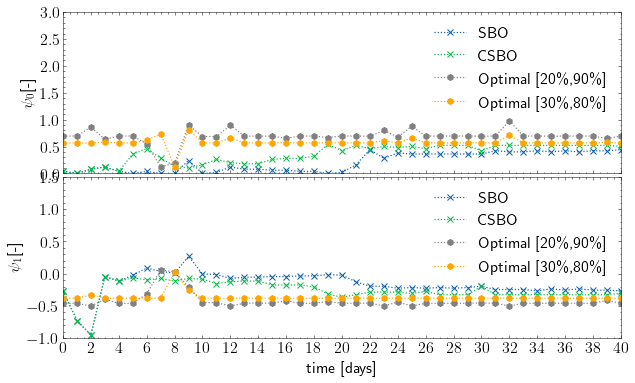

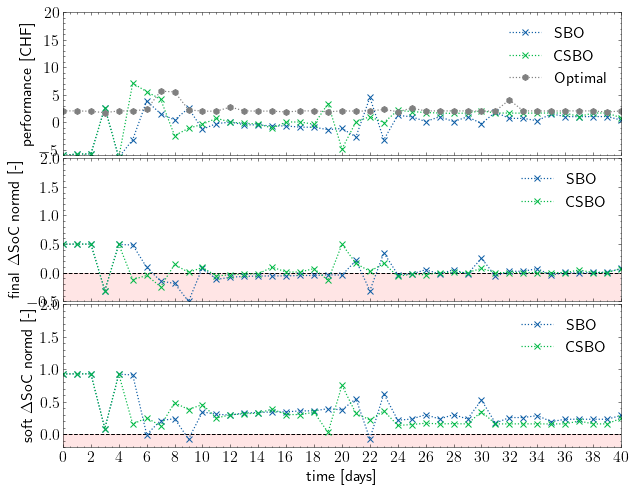

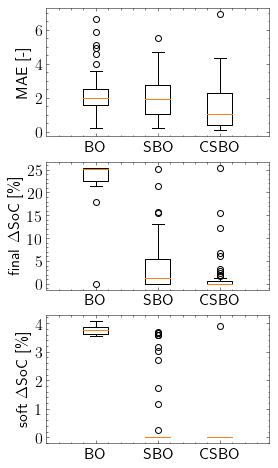

beta: 1 par_num 1


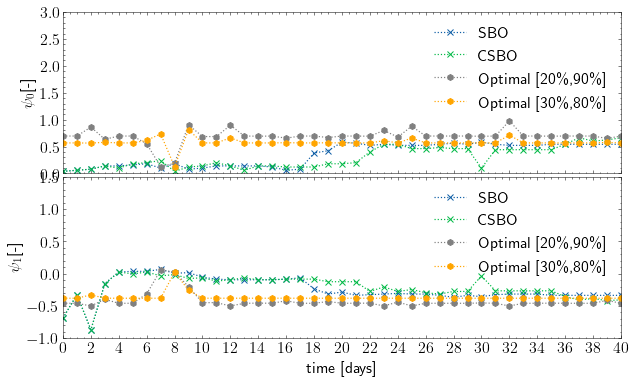

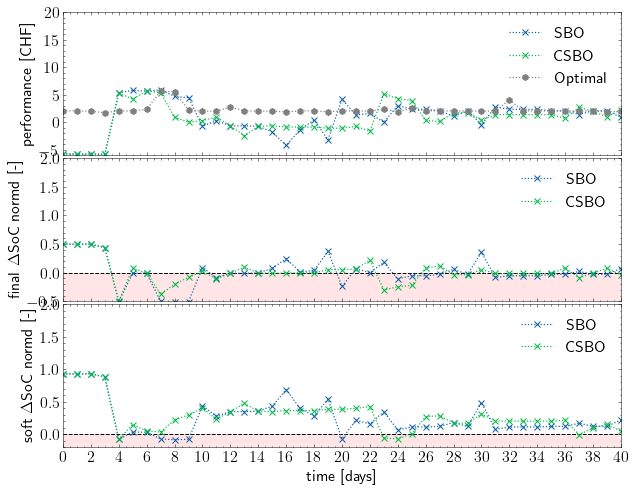

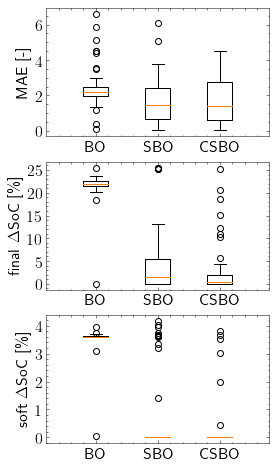

beta: 2 par_num 1


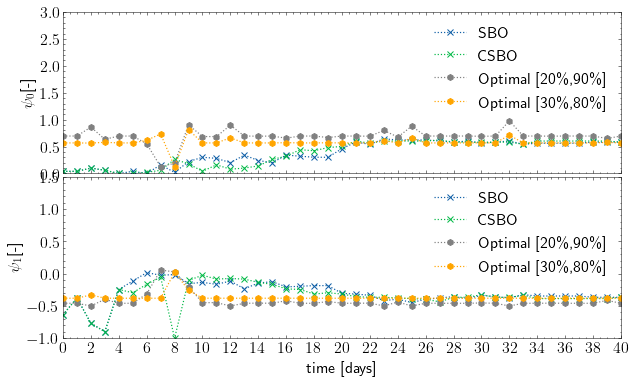

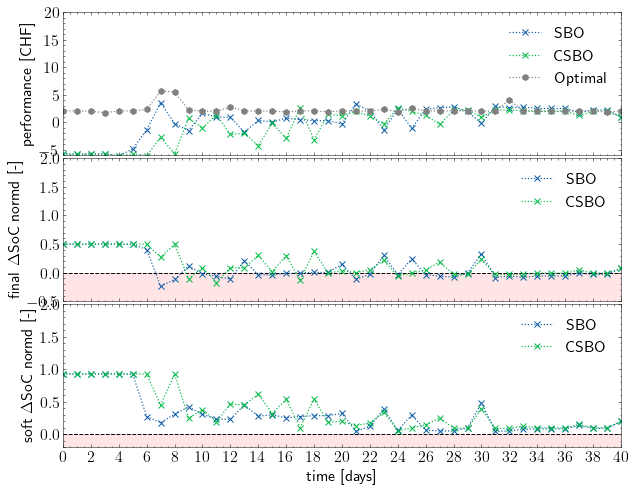

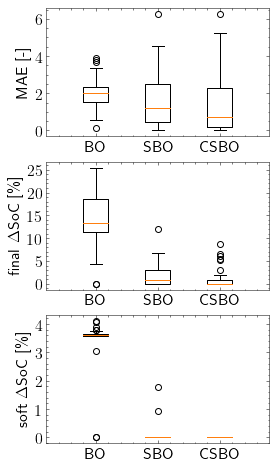

0.5
2
0.5
0.5
2
1
0.5
2
1
1
1
2
False
False
beta: 0.5 par_num 2


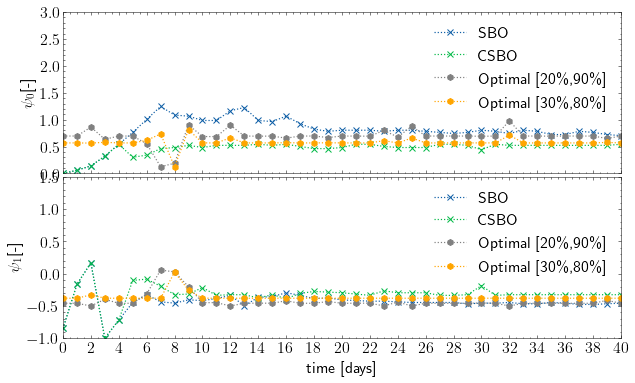

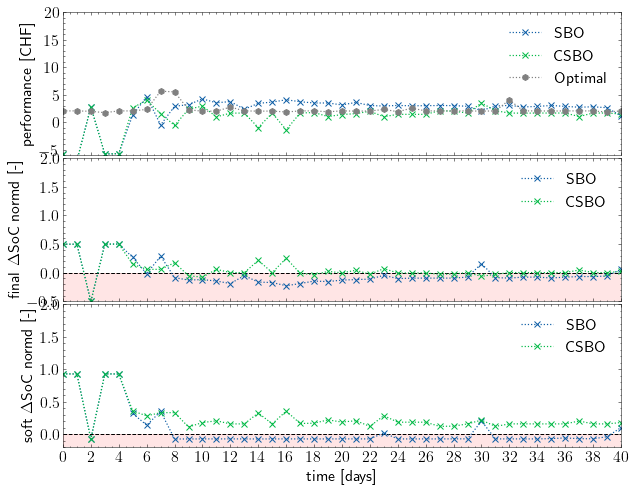

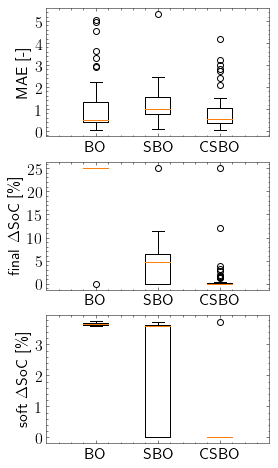

beta: 1 par_num 2


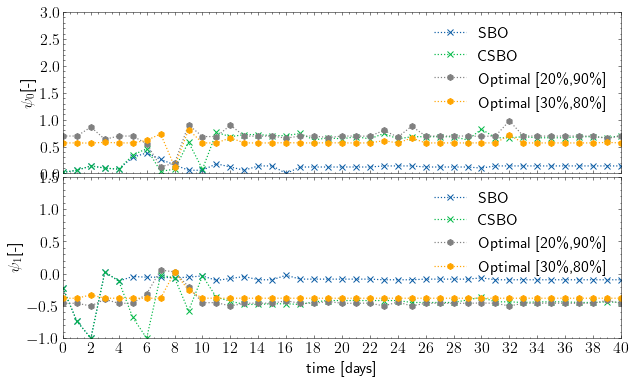

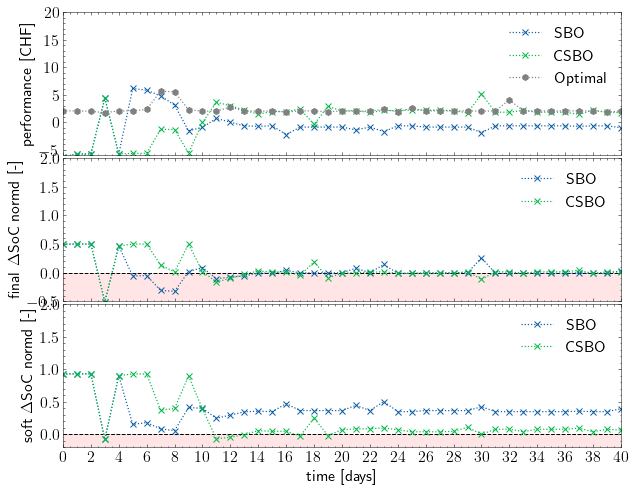

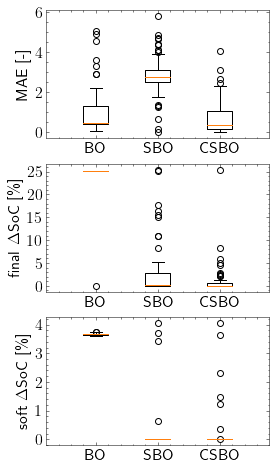

beta: 2 par_num 2


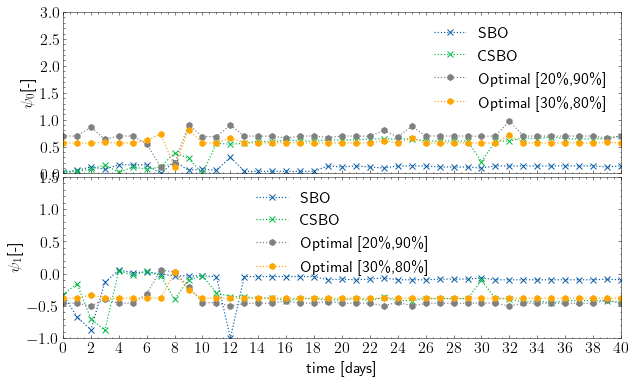

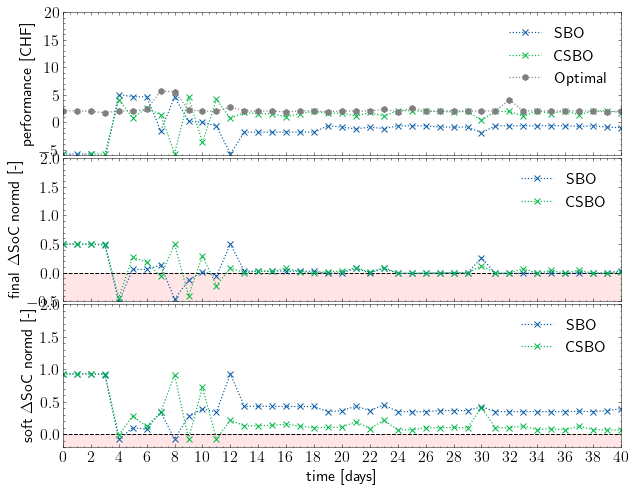

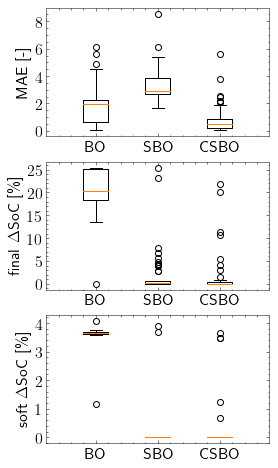

2
0.5
1
0.5
0.5
0.5
2
1
1
1
2
2
False
False
beta: 0.5 par_num 3


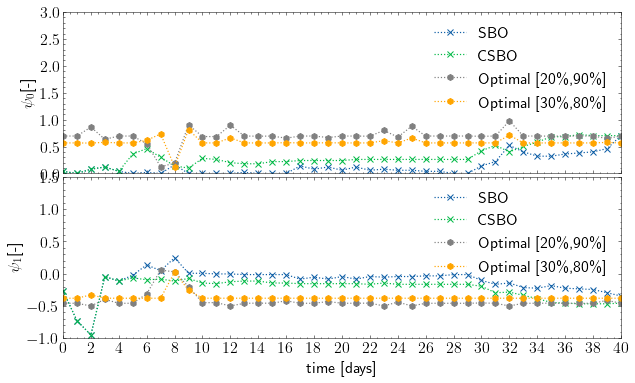

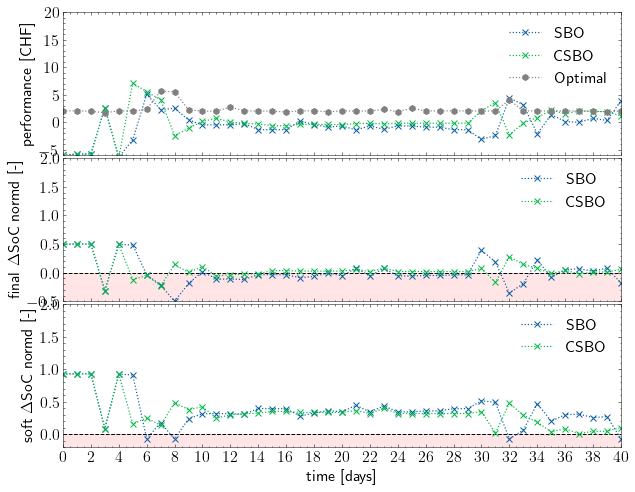

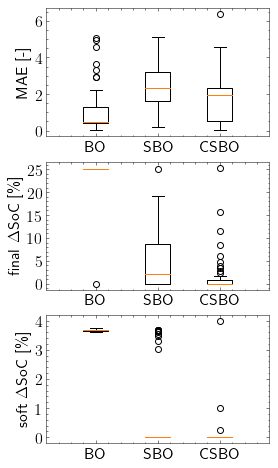

beta: 1 par_num 3


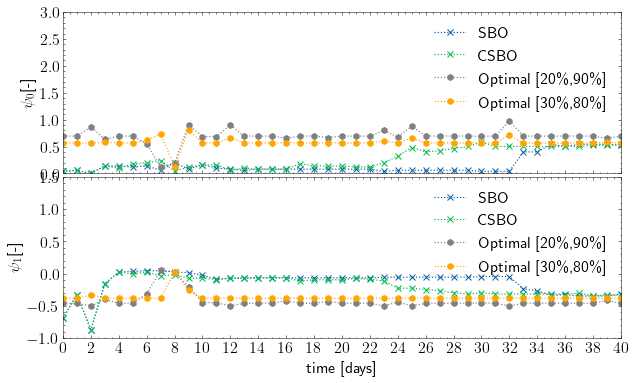

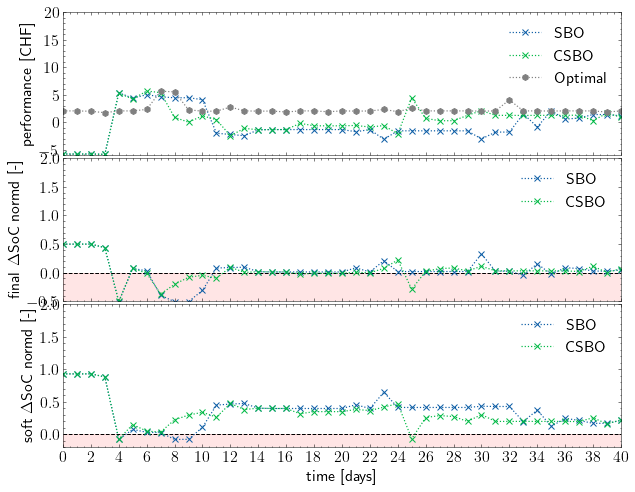

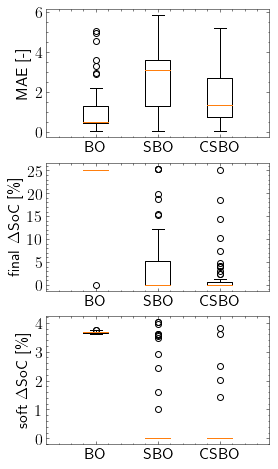

beta: 2 par_num 3


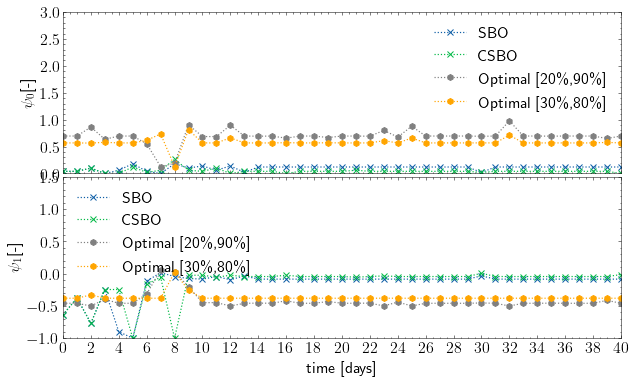

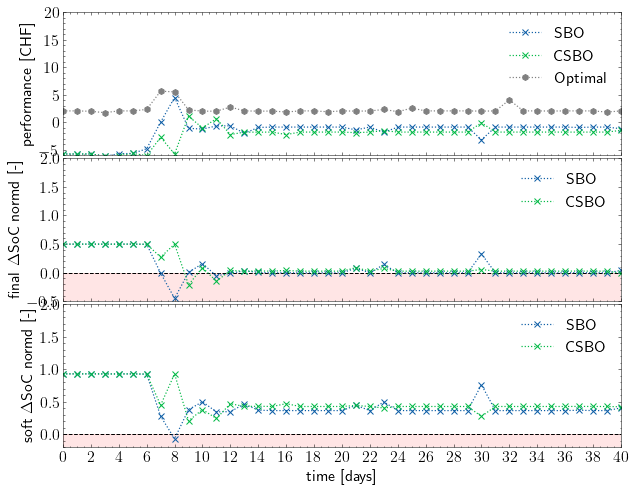

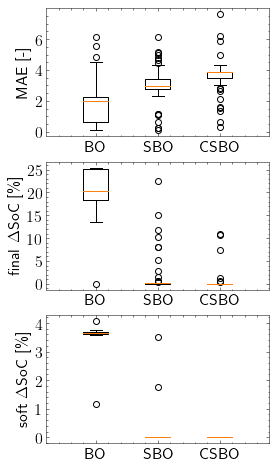

1
0.5
0.5
2
1
1
2
2
0.5
1
0.5
2
False
False
beta: 0.5 par_num 4


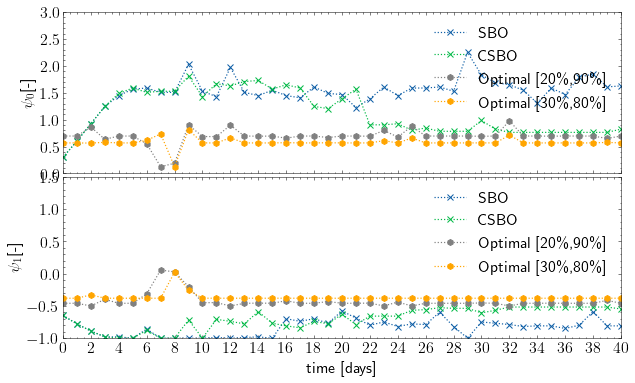

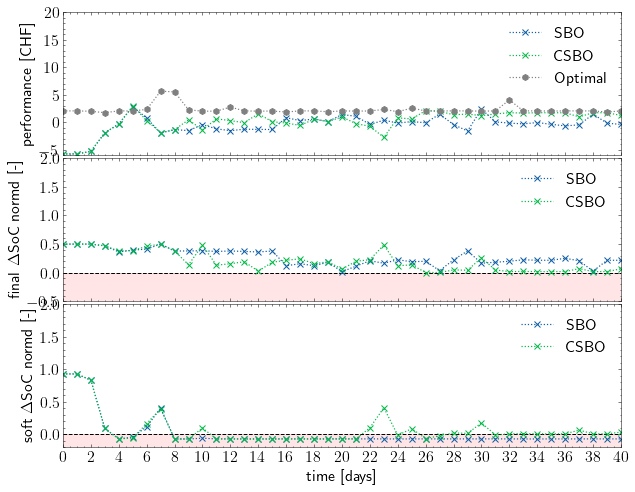

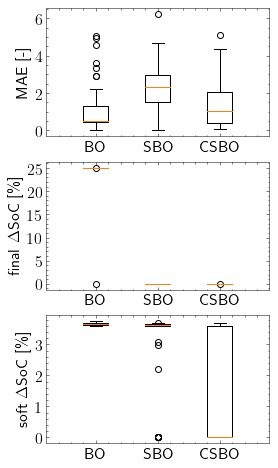

beta: 1 par_num 4


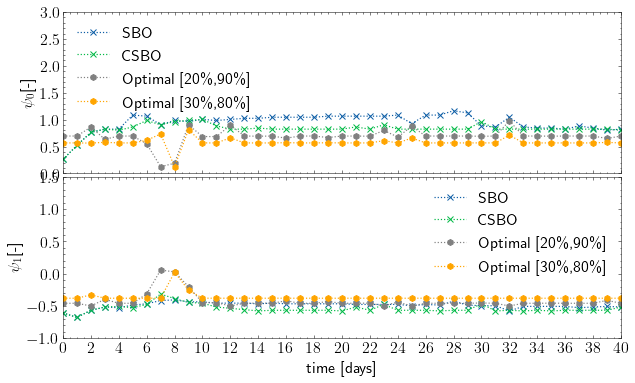

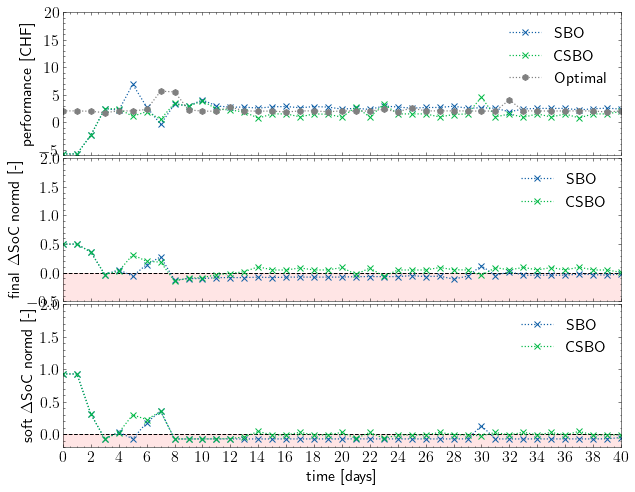

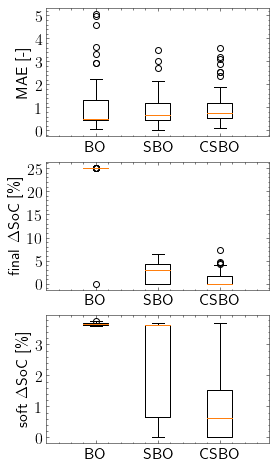

beta: 2 par_num 4


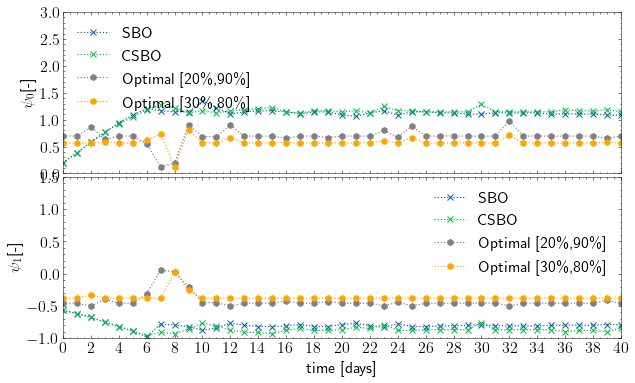

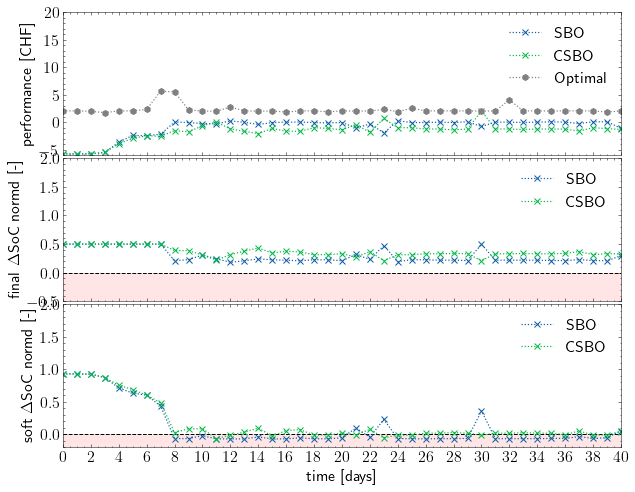

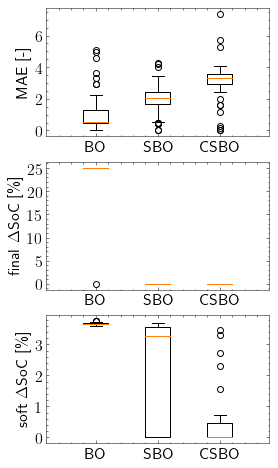

In [21]:
hp_list=[1,2,3,4]
tlim=40
height=8
height2=6
for n in hp_list:
    import glob
    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_25_model_lim9020/x_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    for i, beta in enumerate(betas):
        print(beta)
        if beta.startswith('0.'):
            betas[i]=float(beta.replace('0.','.'))
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas

    par=[]
    for i,path in enumerate(paths):
        par.append(get_data(path))



    par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
    par_df=par_df.set_index(['beta','optype']).sort_index()
    print(np.any(par_df.index.duplicated()))
    par_df=par_df[~par_df.index.duplicated()]

    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_25_model_lim9020/y_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    hpar=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get hp names
    for i, beta in enumerate(betas):
        if beta.startswith('0.'):
            betas[i]=float(beta.replace('0.','.'))
        elif beta.startswith('0'):
            betas[i]=float(beta.replace('0','.'))        
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas
    ct=10 #convergence time
    mae_=[]
    mae=[]
    cnst10=[]
    cnstavg=[]
    sftavg=[]
    cts=[]
    cnst_hist=[]
    cnst_=[]
    sft_=[]
    cst_=[]
    for i,path in enumerate(paths):
        cst=get_data(path)[:]
        cst_.append(cst)
        err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
        mae_.append(np.abs(err))
        mae.append(np.abs(err).mean())
        cnst=get_data(path)[:,1]
        sft=get_data(path)[:,2]        
        cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
        cnst10.append((cnst<-2e-2).astype(int).sum())
        cnst[cnst>0]=0
        cnst_.append(-cnst*50)
        cnstavg.append(cnst.mean()*50)
        sft[sft>0]=0
        sft_.append(-sft*50) 
        sftavg.append(sft.mean()*50)


    eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst':cnstavg,'sft':sftavg,'cst_':cst_,'mae_':mae_,'hst':cnst_hist,'date':dates,
                         'cnst10':cnst10,'cnst_':cnst_,'sft_':sft_,'hpar':hpar})
    eval_df=eval_df.set_index(['beta','optype']).sort_index()
    print(np.any(eval_df.index.duplicated()))
    eval_df=eval_df[~eval_df.index.duplicated()]
    betas_list=[0.5,1,2]
    for beta in betas_list:
        print('beta:',beta,'par_num',n)
        model_label=[ 'SBO','CSBO']

        #Parameter plot
        with plt.style.context('science'):
            plt.rcParams.update({'font.size': 16})                        
            err=25e-2
            iterations=len(par_df.loc[(beta,'CSBO'),'par'][:,0])
            fig,ax=plt.subplots(2,sharex=True,figsize=(10,height2))
            for col in model_label:
                ax[0].plot(range(iterations),par_df.loc[(beta,col),'par'][:,0],':x',label=col,linewidth=1.2)
                ax[1].plot(range(iterations),par_df.loc[(beta,col),'par'][:,1],':x',label=col,linewidth=1.2)
            ax[0].plot(range(iterations),rnd_opt_par[:iterations,0],':h',label='Optimal [20\%,90\%]',linewidth=1.2,color='grey')
            ax[0].plot(range(iterations),rnd_opt_par_[:iterations,0],':h',label='Optimal [30\%,80\%]',linewidth=1.2,color='orange')
            ax[1].plot(range(iterations),rnd_opt_par[:iterations,1],':h',label='Optimal [20\%,90\%]',linewidth=1.2,color='grey')
            ax[1].plot(range(iterations),rnd_opt_par_[:iterations,1],':h',label='Optimal [30\%,80\%]',linewidth=1.2,color='orange')   
            
            ax[0].set_xticks(np.arange(0,iterations,2))
            ax[0].set_ylim([0,3])
            ax[1].set_ylim([-1,1.5])
            ax[0].set_ylabel(r'$\psi_0$[-]')
            ax[0].legend()    
            ax[1].set_ylabel(r'$\psi_1$[-]')
            ax[1].legend()

            plt.xlabel('time [days]')
            plt.xlim([0,tlim])
            plt.subplots_adjust(hspace=0.02)
        plt.savefig(f'QsQf9020/{n}_par_rp_b0_qs_32_qf_55_beta_{beta}.pdf')
        plt.show()
        # Performance and constraint plots    
        with plt.style.context('science'):
            err=25e-2
            plt.rcParams.update({'font.size': 16})            
            iterations=len(par_df.loc[(beta,'CSBO'),'par'][:,0])
            fig,ax=plt.subplots(3,sharex=True,figsize=(10,height))
            for col in model_label:
                ax[0].plot(range(iterations),eval_df.loc[(beta,col),'cst_'][:,0],':x',label=col,linewidth=1.2)
                ax[1].plot(range(iterations),eval_df.loc[(beta,col),'cst_'][:,1],':x',label=col,linewidth=1.2)
                ax[2].plot(range(iterations),eval_df.loc[(beta,col),'cst_'][:,2],':x',label=col,linewidth=1.2)
            ax[0].plot(range(iterations),-rnd_opt_cst[:iterations,0],':h',label='Optimal',linewidth=1.2,color='grey')
            ax[1].hlines(0,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=0,y2=-1,color='red',alpha=0.1)
            ax[2].hlines(0,0,iterations,'k',linestyles='--')
            ax[2].fill_between(range(iterations),y1=0,y2=-1,color='red',alpha=0.1)            
        #     ax[1].plot(range(iterations),rnd_opt_cst[:iterations,1],':h',label='Optimal',linewidth=1.2,color='grey')
            ax[0].set_xticks(np.arange(0,iterations,2))
            ax[0].set_ylabel(r'performance [CHF]')
            ax[0].legend()    
            ax[0].set_ylim([-6,20])            
            ax[1].set_ylim([-0.5,2])
            ax[2].set_ylim([-0.2,2])     
            ax[1].set_ylabel(r'final $\Delta$SoC normd [-]')
            ax[1].legend()
            ax[2].set_ylabel(r'soft $\Delta$SoC normd [-]')
            ax[2].legend()

            plt.xlabel('time [days]')
            plt.xlim([0,tlim])
            plt.subplots_adjust(hspace=0.02)
        plt.savefig(f'QsQf9020/{n}_prf_rp_b0_qs_32_qf_55_beta_{beta}.pdf')
        plt.show()
        model_label=['BO','SBO', 'CSBO']
        model_names=[ 'BO','SBO', 'CSBO']
        # MAE and violation boxplots
        with plt.style.context('science'):
            plt.rcParams.update({'font.size': 16})            
            fig,ax=plt.subplots(3,1,figsize=(4,height))
            for i,col in enumerate(model_label): 
                ax[0].boxplot(eval_df.loc[(beta,col)].mae_,showfliers=True,labels=[model_names[i]],positions=[i/4],widths=0.1)
                ax[0].set_ylabel(r'MAE [-]')
                ax[0].set_xlim([-0.2,0.7]) 
                ax[1].boxplot(eval_df.loc[(beta,col)].cnst_,showfliers=True,labels=[model_names[i]],positions=[i/4],widths=0.1)
                ax[1].set_ylabel(r'final $\Delta$SoC [\%]')
                ax[1].set_xlim([-0.2,0.7]) 
                ax[2].boxplot(eval_df.loc[(beta,col)].sft_,showfliers=True,labels=[model_names[i]],positions=[i/4],widths=0.1)
                ax[2].set_ylabel(r'soft $\Delta$SoC [\%]')     
                ax[2].set_xlim([-0.2,0.7]) 
#                 plt.ylim([-0.001,None])
    #             plt.yscale('log')
            #     plt.ylabel(r'$\textrm{R}^2$')
    #         plt.locator_params(axis="y", nbins=5) 
    #         plt.margins(tight=True)  
        #     plt.legend(['beta'])
        plt.savefig(f'QsQf9020/{n}_model_mae_qs_qf_boxplot_beta_{beta}.pdf')
        plt.show()

In [20]:
eval_df.sort_values('mae')

mae       cnst       sft  \
beta optype                                  
1.0  SBO     0.925267  -2.678181 -2.676343   
     CSBO    1.068228  -0.953576 -1.060480   
0.5  BO      1.149868 -24.627781 -3.665564   
1.0  BO      1.151207 -24.630881 -3.666100   
2.0  BO      1.160475 -24.640374 -3.669817   
0.5  CSBO    1.326025  -0.000094 -1.369716   
2.0  SBO     1.990696   0.000000 -2.326212   
0.5  SBO     2.272046   0.000000 -3.151715   
2.0  CSBO    3.091115   0.000000 -0.354551   
0.5  SBOb    6.022957  -1.073489 -0.654221   
1.0  SBOb    6.205854  -1.177420 -0.552515   
2.0  SBOb    6.234915  -1.292884 -0.360441   

                                                          cst_  \
beta optype                                                      
1.0  SBO     [[-5.747173328655648, 0.4992156246409585, 0.92...   
     CSBO    [[-5.747173328655648, 0.4992156246409585, 0.92...   
0.5  BO      [[-1.8545463833828935, 0.37931557680978006, -0...   
1.0  BO      [[-1.8369750009815933, 0.3793125116741822, -0....   
2.0  BO      [[-1.8227594598617527, 0.3793109241192397, -0....   
0.5  CSBO    [[-5.746478978740792, 0.4992646309888325, 0.92...   
2.0  SBO     [[-5.748049633697424, 0.4991596195889069, 0.92...   
0.5  SBO     [[-5.746478978740792, 0.4992646309888325, 0.92...   
2.0  CSBO    [[-5.748049633697424, 0.4991596195889069, 0.92...   
0.5  SBOb    [[-5.740811219379925, 0.49912845677544665, 0.9...   
1.0  SBOb    [[-5.746233296543985, 0.49917435149066447, 0.9...   
2.0  SBOb    [[-5.746963461059279, 0.4989986691966424, 0.92...   

                                                          mae_  \
beta optype                                                      
1.0  SBO     [2.058535938803694, 0.9416822410302457, 0.0124...   
     CSBO    [1.8884394605944315, 0.38064713935448413, 0.53...   
0.5  BO      [2.2161595726639844, 0.4672713486626434, 0.282...   
1.0  BO      [2.217665953782316, 0.4679739173725399, 0.2784...   
2.0  BO      [2.2214955837739354, 0.628382646035972, 0.2758...   
0.5  CSBO    [3.398466843919911, 1.391073688340101, 2.46932...   
2.0  SBO     [2.236440797984572, 2.296745375914478, 2.52031...   
0.5  SBO     [2.4441928908130937, 3.211060286641831, 4.2943...   
2.0  CSBO    [2.6422425465881907, 1.992217848079492, 3.9647...   
0.5  SBOb    [0.06302824667788487, 0.34702126181024084, 9.1...   
1.0  SBOb    [7.69882573200444, 7.727333082693549, 8.528715...   
2.0  SBOb    [6.8350771763452425, 6.301483859413352, 8.5140...   

                                                           hst  \
beta optype                                                      
1.0  SBO     ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...   
     CSBO    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...   
0.5  BO      ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1.0  BO      ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2.0  BO      ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
0.5  CSBO    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2.0  SBO     ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
0.5  SBO     ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2.0  CSBO    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
0.5  SBOb    ([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...   
1.0  SBOb    ([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,...   
2.0  SBOb    ([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,...   

                        date  cnst10  \
beta optype                            
1.0  SBO     2022_03_15_2354      42   
     CSBO    2022_03_15_2354      16   
0.5  BO      2022_03_16_0124      57   
1.0  BO      2022_03_15_2354      57   
2.0  BO      2022_03_16_0135      57   
0.5  CSBO    2022_03_16_0124       0   
2.0  SBO     2022_03_16_0135       0   
0.5  SBO     2022_03_16_0124       0   
2.0  CSBO    2022_03_16_0135       0   
0.5  SBOb    2022_03_16_0124       5   
1.0  SBOb    2022_03_15_2354       7   
2.0  SBOb    2022_03_16_0135       6   

                                     

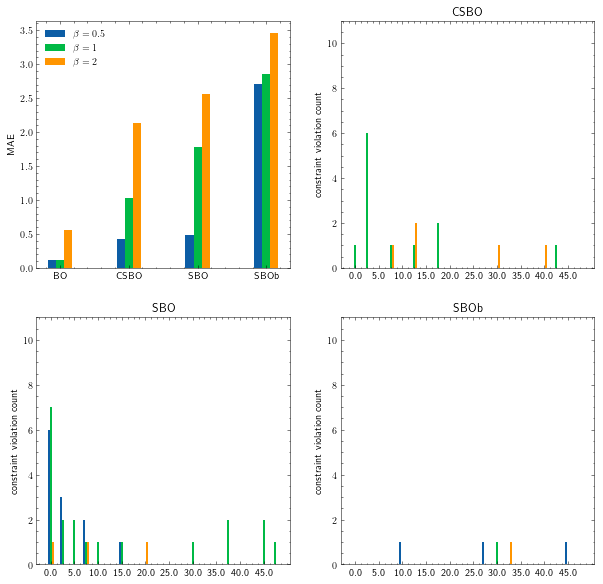

In [149]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(2,2,figsize=(10,10))
    rects1 = axes[0,0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0,0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0,0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0,0].set_ylabel('MAE')
    axes[0,0].legend()
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3_.png')
plt.show()

In [ ]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    rects1 = axes[0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0].set_ylabel('MAE')
    axes[0].legend()
    axes[0].set_xlabel('optimizer')

    n_bins=10
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round().astype(int)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
        ax.set_xlabel('bin [\%]')

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3.png')
plt.show()

In [ ]:
with plt.style.context('science'):
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(3,figsize=(5,5))
    for i,ax in enumerate(axes.flatten()):
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1))
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:], width/3, label=r'$\beta=2$')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('count')
        ax.set_title(op)
        # ax.set_xticks(eval_df.index.levels[1].values)
        ax.legend()

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

    fig.tight_layout()

plt.show()

In [129]:
eval_df.index.levels[1]

Index(['BO', 'CSBO', 'SBO', 'SBOb'], dtype='object', name='optype')

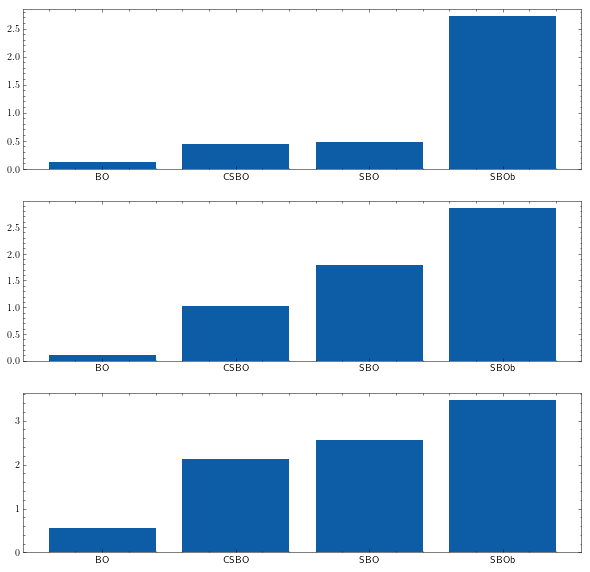

In [103]:
with plt.style.context('science'):
    fig,axes=plt.subplots(len(eval_df.index.levels[0]),figsize=(10,10))
    for i,ax in enumerate(axes.flatten()):
        df=eval_df.loc[eval_df.index.levels[0][i]]
        ax.bar(df.index,df.mae)

plt.show()

# GP evaluation

In [3]:
gps_b2=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike3_b2__2022_03_08_0450')
gps_b05=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike3_b05__2022_03_08_044')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
optb2=safeopt.SafeOpt(gps_b2[1],parameter_set,fmin=0,num_contexts=1)
optb05=safeopt.SafeOpt(gps_b05[1],parameter_set,fmin=0,num_contexts=1)

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning


3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 1.0)]
3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 1.0)]


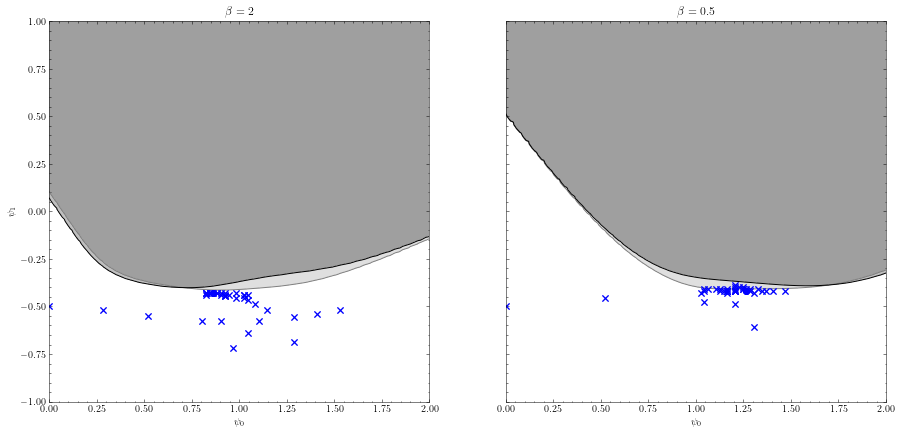

In [91]:
with plt.style.context('science'):
    fig,ax=plt.subplots(1,2,figsize=(15,7),sharey=True)
    optb2.context=[[0]]
    optb2.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0], colors='grey',colorbar=False)
    optb2.context=[[1]]
    optb2.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0],colors='black',colorbar=False)
    optb05.context=[[0]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1], colors='grey',colorbar=False)
    optb05.context=[[1]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1],colors='black',colorbar=False)
    ax[0].set_xlim([0,2])
    ax[1].set_xlim([0,2])
    ax[0].set_title(r'$\beta =2$')
    ax[1].set_title(r'$\beta =0.5$')
    ax[0].set_xlabel(r'$\psi_{0}$')
    ax[0].set_ylabel(r'$\psi_{1}$')    
    ax[1].set_xlabel(r'$\psi_{0}$')
    ax[1].set_title(r'$\beta =0.5$')
plt.savefig('../fig_scripts/qf_const_ctxt_loglike4.png')    
plt.show()

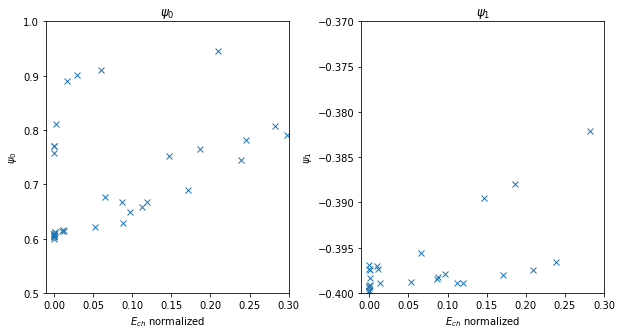

In [175]:
rnd_opt_cst=get_data('NL_opt/rnd_opt_cst_winter_3_1_2_2022_03_02_0252.npy')
rnd_opt_par=get_data('NL_opt/rnd_opt_par_winter_3_1_2_2022_03_02_0252.npy')
e_ch=get_data('sim_data_312_winter_rp0_qf_55/ech_winter_2022_03_08_0707.npy')
# rnd_opt_par=rnd_opt_par[~np.isnan(rnd_opt_par)]

fig,ax=plt.subplots(1,2,figsize=(10,5))
with plt.style.context('science'):
    ax[0].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,0],'x')
    ax[1].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,1],'x')
    ax[0].set_xlim([-0.01,0.3])
    ax[1].set_xlim([-0.01,0.3])
    ax[0].set_ylim([0.5,1])
    ax[1].set_ylim([-0.4,-0.37])
    ax[0].set_title(r'$\psi_0$')
    ax[0].set_xlabel(r'$E_{ch}$ normalized')
    ax[0].set_ylabel(r'$\psi_{0}$')    
    ax[1].set_xlabel(r'$E_{ch}$ normalized')
    ax[1].set_ylabel(r'$\psi_{1}$')
    ax[1].set_title(r'$\psi_1$')
plt.subplots_adjust(wspace=0.3)
plt.savefig('../fig_scripts/par_ech_corr_winter.png')

In [167]:
gps=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike1_b05__2022_03_08_0421')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
opt=safeopt.SafeOpt(gps,parameter_set,fmin=[-np.inf,0],num_contexts=1)


This is local package in rbc-parameter-tuning
